<a href="https://colab.research.google.com/github/alans123s/Automatic_Attendence_OneShot-Learning/blob/main/C%C3%B3digo_Fonte_Alan_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações

In [ ]:
# @title Downloads - **RUN THIS**
!pip install tensorflow-gpu
!sudo pip install mtcnn


     |████████████████████████████████| 394.3MB 44kB/s 
     |████████████████████████████████| 2.3MB 5.2MB/s 


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import os
from skimage import io
import pandas as pd
from tqdm import tqdm

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
        
import keras
from keras.models import load_model
from google.colab import drive

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15

In [ ]:
  #mouting drive
drive.mount('/content/drive')

Mounted at /content/drive


# UTILS

## extract faces from images function(MTCNN)

In [ ]:


def extract_face(class_batch, required_size=(160, 160)):
  # load image from file
  #image = Image.open(filename)
  # convert to RGB, if needed
  #image = image.convert('RGB')
  # convert to array
  #pixels = asarray(image)

	# create the detector, using default weights
  detector = MTCNN()
	# detect faces in the image
  face_array = []
  with tf.device('/device:GPU:0'):
    for photo in class_batch:
      results = detector.detect_faces(photo)
      
      # extract the bounding box from the first face
      b=len(results)
      a=1
      for result in results:
        x1, y1, width, height = result['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = photo[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        a=a+1
        face_array.append(asarray(image))
  return face_array

## import images from a class

In [ ]:
def import_class_images(class_path,startswith = 'P'):
    # inicializa matrizes X e y
    X = []

    # percorre todos os diretorios da base class_photos e carrega as imagens
    imgs_path = class_path
    dir =os.listdir(imgs_path)
    i=0
    for f in sorted(dir): 
        if f.startswith(startswith):
              if f.endswith(".png"):
                  # copia msg imagem para os 3 canais
                  X.append(io.imread(os.path.join(imgs_path,f)))   
                  i = i + 1
    return asarray(X)

## get embeddings from a batch of faces

In [ ]:
def get_embedding(batch):
    

    i = 0
    # scale pixel values
    embeddings_array = []
    for face_pixels in batch:
        
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        embeddings_array.append(face_pixels)
        i += 1

    
    
    # make prediction to get embedding
    
    face_embeddings = faceNet.predict(asarray(embeddings_array))
    return face_embeddings

## pre-processing in images for resizing

In [ ]:
def pre_processing (batch):    
    face_array=[]
    for face in batch:
        image = Image.fromarray(face)
        image = image.resize((160,160))
        face_array.append(asarray(image))
    return asarray(face_array)

## Embeddings cosine similarity

In [ ]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

## import training/evaluation images function

In [ ]:
def import_query_images(path,size=10):
    # inicializa matrizes X e y
    X = []
    # percorre todos os diretorios da base class_photos e carrega as imagens
    i=0
    dir = os.listdir(path)
    with tf.device('/device:GPU:0'):
        for f in tqdm(sorted(dir)): 
            if (i>=size):
                break
            if f.startswith('Q'):
                # copia msg imagem para os 3 canais
                #f =  Q+f+.png(f tem 4 numeros)
                X.append(io.imread(os.path.join(path,f)))   
                i = i + 1
        return asarray(X)


## images standardization function

In [ ]:
def standard (batch):
    i = 0
    # scale pixel values
    embeddings_array = []
    for face_pixels in batch:
        
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        embeddings_array.append(face_pixels)
        i += 1    
    return embeddings_array

# IMPORTING AND PROCESSING DATASET

## importing images for training

In [ ]:
query_path = "/content/drive/My Drive/redespdi/datasets/DB_Sala/DB/query" 
class_query_batch=import_query_images(query_path,5000)

validation_X=class_query_batch[:464]
training_X=class_query_batch[464:3675]
test_X = class_query_batch[3675:]

100%|██████████| 4898/4898 [58:18<00:00,  1.40it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


##Import images for enroll

In [ ]:
enroll_path = "/content/drive/My Drive/redespdi/datasets/DB_Sala/DB/enroll" 
enroll_batch = import_class_images(enroll_path,'E')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## importing training labels

In [ ]:
query_table_path="/content/drive/My Drive/redespdi/datasets/DB_Sala/DB/data/query_database.npy"
X = np.load(query_table_path,allow_pickle=True) 

data = pd.DataFrame.from_dict(data = X[0], orient = 'columns')
validation_data = data[data['day']<=1]  #id < 343
training_data = data[(data['day']>1) & (data['day']<18)] #343 e 3429
test_data = data[(data['day']>=18)]  #3429

In [ ]:
training_data

,id,day,photo,num_face,rect,identity
464,464,2,0,0,"[(652, 1134) (700, 1182)]",53
465,465,2,0,1,"[(952, 1142) (1004, 1194)]",12
466,466,2,0,2,"[(802, 1146) (854, 1198)]",49
467,467,2,0,3,"[(1521, 1151) (1568, 1198)]",2
468,468,2,0,4,"[(387, 1147) (440, 1200)]",13
...,...,...,...,...,...,...
3670,3670,17,5,26,"[(660, 2716) (898, 2954)]",32
3671,3671,17,5,27,"[(2313, 2653) (2555, 2895)]",5
3672,3672,17,5,28,"[(1293, 1839) (1342, 1900)]",18
3673,3673,17,5,29,"[(1477, 1790) (1516, 1840)]",12


In [ ]:
# saving labels
validation_y = asarray(validation_data['identity'])
training_y = asarray(training_data['identity'])
test_y = asarray(test_data['identity'])

## rezising images

In [ ]:
validation_X_extracted = pre_processing(validation_X)
training_X_extracted = pre_processing(training_X)
test_X_extracted = pre_processing(test_X)

## standardizing images

In [ ]:
validation_X_std = standard(validation_X_extracted)
training_X_std = standard(training_X_extracted)
# only the images used in training are standardized

# FINETUNING FACENET

## importing faceNet model

In [ ]:
# load the model
facenet_dic='/content/drive/My Drive/redespdi/facenetKeras/model/facenet_keras.h5'
faceNet = load_model(facenet_dic,compile=True)


## preparing new model


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# setting only the new layer to be trainable
faceNet.trainable = False
inputs = faceNet.input
outputs = tf.keras.layers.Dense(67,activation='softmax')(faceNet.output)
# creating a new model for classification with a new dataset
model = tf.keras.Model(inputs, outputs,name='Model')

## compile new model

In [ ]:
model.compile(optimizer=keras.optimizers.Adagrad(0.003),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

## training new model

In [ ]:
history = model.fit(x = asarray(training_X_std),y = training_y,epochs=50,validation_data=(asarray(validation_X_std),validation_y),batch_size=32)

Epoch 1/50
101/101 [==============================] - 53s 162ms/step - loss: 4.6569 - accuracy: 0.0248 - val_loss: 3.8426 - val_accuracy: 0.1078
Epoch 2/50
101/101 [==============================] - 13s 128ms/step - loss: 3.6333 - accuracy: 0.1505 - val_loss: 3.2023 - val_accuracy: 0.2694
Epoch 3/50
101/101 [==============================] - 13s 128ms/step - loss: 2.9604 - accuracy: 0.3314 - val_loss: 2.7389 - val_accuracy: 0.3987
Epoch 4/50
101/101 [==============================] - 13s 128ms/step - loss: 2.5191 - accuracy: 0.4810 - val_loss: 2.3838 - val_accuracy: 0.5216
Epoch 5/50
101/101 [==============================] - 13s 127ms/step - loss: 2.1749 - accuracy: 0.5989 - val_loss: 2.1027 - val_accuracy: 0.6142
Epoch 6/50
101/101 [==============================] - 13s 127ms/step - loss: 1.8679 - accuracy: 0.7025 - val_loss: 1.8757 - val_accuracy: 0.6853
Epoch 7/50
101/101 [==============================] - 13s 127ms/step - loss: 1.6211 - accuracy: 0.7696 - val_loss: 1.6895 - val_ac

## plotting  model accuracy and loss

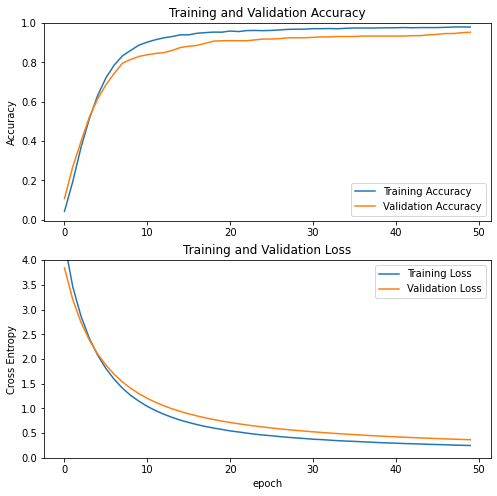

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2,1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## preparing last layer of new classification model for fine tuning

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
faceNet.trainable= True
print("Number of layers in the base model: ", len(faceNet.layers))
fine_tune_at = 300
for layer in faceNet.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  426


## fine-tuning new classification model

In [ ]:

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.003/10),
              metrics=['accuracy'])

history_fine = model.fit(x = asarray(training_X_std),y = training_y,epochs=80,validation_data=(asarray(validation_X_std),validation_y),batch_size=32,initial_epoch=history.epoch[-1],)

Epoch 50/80
101/101 [==============================] - 32s 215ms/step - loss: 0.2015 - accuracy: 0.9680 - val_loss: 0.3180 - val_accuracy: 0.9612
Epoch 51/80
101/101 [==============================] - 19s 192ms/step - loss: 0.0163 - accuracy: 0.9984 - val_loss: 0.1822 - val_accuracy: 0.9763
Epoch 52/80
101/101 [==============================] - 19s 193ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2834 - val_accuracy: 0.9763
Epoch 53/80
101/101 [==============================] - 19s 193ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.1704 - val_accuracy: 0.9806
Epoch 54/80
101/101 [==============================] - 19s 192ms/step - loss: 5.3357e-04 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9784
Epoch 55/80
101/101 [==============================] - 19s 193ms/step - loss: 7.2565e-04 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 0.9849
Epoch 56/80
101/101 [==============================] - 19s 193ms/step - loss: 6.2183e-05 - accuracy: 1.0000 - val_lo

## plotting accuracy and loss of the fine-tuned model

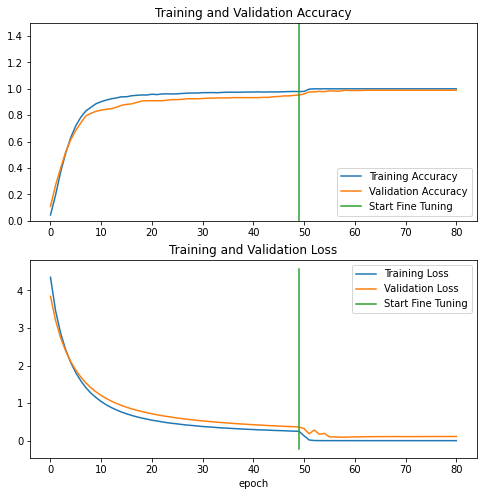

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

initial_epochs = 50
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Removing last layer of new model

In [ ]:
inputs = model.input
outputs = model.get_layer(name='Bottleneck_BatchNorm').output
faceNet_tunned = tf.keras.Model(inputs, outputs,name='Model_tunned')

In [ ]:
#faceNet_tunned.save(filepath='/content/drive/My Drive/Projeto/FaceNet_tunned/FaceNet_tunned_GOD_.h5',save_format='h5')

#  TESTING MODEL-TUNNED

## get images embeddings

In [ ]:
validation_X_embeddings = get_embedding(batch = asarray(validation_X_extracted))
training_X_embeddings = get_embedding(batch = asarray(training_X_extracted))
test_X_embeddings = get_embedding(batch=asarray(test_X_extracted))

## testing accuracy o model in comparation task 

In [ ]:
acertos=0
erros=0
nao_encontrados=0
acertos_arr=[]
erros_arr=[]
index_teste = 0
for teste_emb in tqdm(test_X_embeddings):
  min1 = np.inf
  index1 = 0
  finded=False
  aux = 0
  for enroll_emb in validation_X_embeddings[:-1]:
    result = findCosineSimilarity(teste_emb, enroll_emb)
    if result < min1:
      finded=True
      min1 = result
      index1 = aux
    aux +=1
  if finded:
    if (validation_y[index1] == test_y[index_teste]):
      acertos += 1
      acertos_arr.append((index1,index_teste))
    else:
      erros +=1
      erros_arr.append((index1,index_teste))
  else:
    nao_encontrados+=1
    erros+=1
  index_teste += 1 
print('\n')
print('accuracy: ')
print(acertos/(acertos+erros))

#MODEL ACCURACY

In [ ]:
target_emb = get_embedding(pre_processing(enroll_batch))

In [ ]:
def metrics (infered_emb,target_emb,y):
    encontrados=[]
    index_teste = 0
    
    for teste_emb in infered_emb:
        min1 = 0.5
        index1 = 0
        finded=False
        aux = 0
        for enroll_emb in target_emb:
            result = findCosineSimilarity(teste_emb, enroll_emb)
            if result < min1:
                finded=True
                min1 = result
                index1 = aux
            aux +=1
        if finded:
            encontrados.append(index1)


    TP = 0
    FP = 0
    FN = 0

    for i in encontrados:
        if i in list(y):
            TP += 1
        else:
            FP += 1


    for i in list(y):
        if i not in encontrados:
            FN += 1

        
    TN = 67 - (TP + FP + FN)

    acc = (TP + TN)  / (TP + FP + TN + FN)
    rec = TP / (TP+FN)
    prec = TP / (TP + FP)
    F1 = 2*(prec*rec/(prec+rec))
     
    print(f'\n acuracia: {acc}   recall: {rec}    precision: {prec}  F1 score: {F1}')    
    
    return acc,rec,prec,F1


    

In [ ]:
#Comportamento do modelo na base de teste, 7 dias finais.

acc =[]
rec = []
prec = []
F1 = []
for i in tqdm(range(18,25)):
    class_image = import_class_images(class_path='/content/drive/My Drive/redespdi/datasets/DB_Sala/DB/class_photos/D{0:03}'.format(i))
    day = data[data['day'] ==i]
    y = set(day['identity'])

    faces_box = extract_face(class_image)
    faces_emb = get_embedding(faces_box)
    a,r,p,f1 = metrics(faces_emb,target_emb,y)
    acc.append(a)
    rec.append(r)
    prec.append(p)
    F1.append(f1)

print('Media acc',(sum(acc)/len(acc)))
print('Media rec',(sum(rec)/len(rec)))
print('Media prec',(sum(prec)/len(prec)))
print('Media F1 score',(sum(F1)/len(F1)))

 14%|█▍        | 1/7 [00:28<02:48, 28.15s/it]


 acuracia: 1.0   recall: 1.0    precision: 1.0  F1 score: 1.0


 29%|██▊       | 2/7 [00:53<02:16, 27.36s/it]


 acuracia: 1.0   recall: 1.0    precision: 1.0  F1 score: 1.0


 43%|████▎     | 3/7 [01:16<01:44, 26.12s/it]


 acuracia: 1.0   recall: 1.0    precision: 1.0  F1 score: 1.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
 57%|█████▋    | 4/7 [02:02<01:35, 31.98s/it]


 acuracia: 0.9850746268656716   recall: 0.9953488372093023    precision: 1.0  F1 score: 0.9976689976689977


 71%|███████▏  | 5/7 [02:32<01:03, 31.52s/it]


 acuracia: 0.9850746268656716   recall: 0.9925925925925926    precision: 1.0  F1 score: 0.996282527881041


 86%|████████▌ | 6/7 [03:04<00:31, 31.49s/it]


 acuracia: 0.9701492537313433   recall: 0.9852941176470589    precision: 1.0  F1 score: 0.9925925925925926


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 7/7 [03:57<00:00, 33.97s/it]


 acuracia: 0.9701492537313433   recall: 0.9954954954954955    precision: 0.9954954954954955  F1 score: 0.9954954954954955
Media acc 0.9872068230277186
Media rec 0.9955330061349212
Media prec 0.9993564993564993
Media F1 score 0.9974342305197323
